# Runtime ≈	1 minute




# This notebook completes the process of wrangling the text for EDA and other future analyses.

# The processing is the following order:
*   Scispacy - Acronyms
*   General Cleaning
* Spacy - Lemmatization

In [1]:
try:
    from google.colab import drive

    drive.mount('./drive/')

    %cd drive/My \ Drive/Text_Summarization

except:
  
    print("No Colab Environment")

No Colab Environment


In [2]:
import json
import pandas as pd
import numpy as np
import re
import seaborn as sns

import matplotlib

matplotlib.rcParams["figure.figsize"] = (20, 7)

# Load Data

In [3]:
with open("./Data/raw/Telehealth_article_texts.txt") as f:
    #Skip header
    for i in range(4):
        next(f) 
    corpus = f.read()

In [4]:
dict_articles = json.loads(corpus.replace("\n",""))
df_articles = pd.DataFrame.from_dict(dict_articles,orient="index",columns=["Content"]).reset_index().drop(columns=["index"])

df_articles.head()

,Content
0,Veterans face a variety of stressors related t...
1,The impact of the COVID-19 pandemic on the chi...
2,"In November 2019, COVID-19—the infectious, hig..."
3,Anxiety and depressive disorders are among the...
4,"In mid-March, 2020, the authors—as well as the..."


In [5]:
df_metadata = pd.read_excel("./Data/raw/Metadata_telehealth_article_key_2.25.xlsx",sheet_name="Tied_to_Notebook",index_col="Index")

df_metadata.head()

,Journal Title,Article Title,Date Published,Authors,Abstract,Keywords,Citation
Index,,,,,,,
0,Psychological Servies,The Effectiveness of Telepsychology With Veter...,2021,Michael J. McClellan; Richard Osbaldiston; Ron...,Veterans face a variety of stressors due to th...,"KEYWORDS:\n\ntelepsychology, meta-analysis, ve...","McClellan, M. J., Osbaldiston, R., Wu, R., Yea..."
1,"Psychology, Public Policy, and Law",Making the Case for Videoconferencing and Remo...,2021,Milfred D. Dale; Desiree Smith,The COVID-19 pandemic and its requirements for...,"KEYWORDS:\n\nremote child custody evaluations,...","Dale, M. D., & Smith, D. (2021). Making the ca..."
2,"Psychology, Public Policy, and Law","Forensic E-Mental Health: Review, Research Pri...",2021,Lauren E. Kois; Jennifer Cox; Ashley T. Peck,Forensic e-mental health is an area of psychol...,"KEYWORDS:\n\nforensic e-mental health, telehea...","Kois, L. E., Cox, J., & Peck, A. T. (2021). Fo..."
3,Training and Education in Professional Psychology,Moving Toward a New Era of Telepsychology in U...,2021,Allison L. Baier; Sarah Danzo,Many university training clinics are facing nu...,"KEYWORDS:\n\neducation and training, telepsych...","Baier, A. L., & Danzo, S. (2021). Moving towar..."
4,Practice Innovations,Navigating Changes in the Physical and Psychol...,2021,Liat Shklarski; Allison Abrams; Elana Bakst,The emergence of the Covid-19 pandemic at the ...,"KEYWORDS:\n\nremote psychotherapy, Covid-19, p...","Shklarski, L., Abrams, A., & Bakst, E. (2021)...."


In [6]:
#Ensure both Indexes are of same type before merge
assert df_metadata.index.dtype == df_articles.index.dtype

#Merge dataframes
df_metadata = df_metadata.merge(df_articles,left_index=True,right_index=True,how="left")

df_metadata.head()

,Journal Title,Article Title,Date Published,Authors,Abstract,Keywords,Citation,Content
Index,,,,,,,,
0,Psychological Servies,The Effectiveness of Telepsychology With Veter...,2021,Michael J. McClellan; Richard Osbaldiston; Ron...,Veterans face a variety of stressors due to th...,"KEYWORDS:\n\ntelepsychology, meta-analysis, ve...","McClellan, M. J., Osbaldiston, R., Wu, R., Yea...",Veterans face a variety of stressors related t...
1,"Psychology, Public Policy, and Law",Making the Case for Videoconferencing and Remo...,2021,Milfred D. Dale; Desiree Smith,The COVID-19 pandemic and its requirements for...,"KEYWORDS:\n\nremote child custody evaluations,...","Dale, M. D., & Smith, D. (2021). Making the ca...",The impact of the COVID-19 pandemic on the chi...
2,"Psychology, Public Policy, and Law","Forensic E-Mental Health: Review, Research Pri...",2021,Lauren E. Kois; Jennifer Cox; Ashley T. Peck,Forensic e-mental health is an area of psychol...,"KEYWORDS:\n\nforensic e-mental health, telehea...","Kois, L. E., Cox, J., & Peck, A. T. (2021). Fo...","In November 2019, COVID-19—the infectious, hig..."
3,Training and Education in Professional Psychology,Moving Toward a New Era of Telepsychology in U...,2021,Allison L. Baier; Sarah Danzo,Many university training clinics are facing nu...,"KEYWORDS:\n\neducation and training, telepsych...","Baier, A. L., & Danzo, S. (2021). Moving towar...",Anxiety and depressive disorders are among the...
4,Practice Innovations,Navigating Changes in the Physical and Psychol...,2021,Liat Shklarski; Allison Abrams; Elana Bakst,The emergence of the Covid-19 pandemic at the ...,"KEYWORDS:\n\nremote psychotherapy, Covid-19, p...","Shklarski, L., Abrams, A., & Bakst, E. (2021)....","In mid-March, 2020, the authors—as well as the..."


In [7]:
JournalCrosswalk = pd.read_excel('./Data/raw/JournalTitles.xlsx')
JournalCrosswalk.set_index('Journal', inplace=True)

In [8]:
JournalCrosswalk.head()

,Journal Code,Peer Review System,Journal Subfield
Journal,,,
Asian American Journal of Psychology,AAP,EM (AJP),Social Psychology
Journal of Abnormal Psychology,ABN,EM,Clinical & Counseling Psychology
"Psychology of Aesthetics, Creativity, and the Arts",ACA,EM,Social Psychology
Psychology of Addictive Behaviors,ADB,EM,Health Psychology & Medicine
American Psychologist,AMP,EM,General Psychology


In [9]:
df_metadata.dtypes

Journal Title     object
Article Title     object
Date Published     int64
Authors           object
Abstract          object
Keywords          object
Citation          object
Content           object
dtype: object

In [10]:
df_metadata["Content_Length"] = df_metadata["Content"].apply(lambda text: len(text))
df_metadata["Abstract_Length"] = df_metadata["Abstract"].apply(lambda text: len(str(text)))
df_metadata["Parsed_Keywords"] = df_metadata["Keywords"].apply(lambda keywords: str(keywords).replace("\n\n"," ").split()[1:])
df_metadata["Parsed_Keywords_Length"] = df_metadata["Parsed_Keywords"].apply(lambda text: len(text))
df_metadata["Journal Title"] = df_metadata["Journal Title"].replace('Psychological Servies', 'Psychological Services')
subfield = []
for i in df_metadata['Journal Title']:
  print(i)
  try:
    if i == 'Clinical Psychology: Science and Practice': # Journal is missing from Crosswalk
      subfield.append('Clinical & Counseling Psychology')
    else:
      subfield.append(JournalCrosswalk['Journal Subfield'][i])
  except:
    subfield.append('No Match')
    
df_metadata["Subfield"] = subfield

#Have an idea of reference amount per document
df_metadata["et_al_Count"] = df_metadata["Content"].apply(lambda text: len(list(re.finditer("et al",text))))


Psychological Services
Psychology, Public Policy, and Law
Psychology, Public Policy, and Law
Training and Education in Professional Psychology
Practice Innovations
American Psychologist
Psychological Services
Canadian Psychology/Psychologie canadienne
Psychological Assessment
Journal of Psychotherapy Integration
Professional Psychology: Research and Practice
Journal of Psychotherapy Integration
Journal of Psychotherapy Integration
Practice Innovations
Practice Innovations
Journal of Psychotherapy Integration
Professional Psychology: Research and Practice
Professional Psychology: Research and Practice
Professional Psychology: Research and Practice
Professional Psychology: Research and Practice
Rehabilitation Psychology
Psychological Services
Translational Issues in Psychological Science
Clinical Psychology: Science and Practice
Clinical Psychology: Science and Practice
Clinical Psychology: Science and Practice
Clinical Psychology: Science and Practice
American Psychologist
Families, Sys

In [11]:
df_metadata.head()

,Journal Title,Article Title,Date Published,Authors,Abstract,Keywords,Citation,Content,Content_Length,Abstract_Length,Parsed_Keywords,Parsed_Keywords_Length,Subfield,et_al_Count
Index,,,,,,,,,,,,,,
0,Psychological Services,The Effectiveness of Telepsychology With Veter...,2021,Michael J. McClellan; Richard Osbaldiston; Ron...,Veterans face a variety of stressors due to th...,"KEYWORDS:\n\ntelepsychology, meta-analysis, ve...","McClellan, M. J., Osbaldiston, R., Wu, R., Yea...",Veterans face a variety of stressors related t...,37477,2411,"[telepsychology,, meta-analysis,, veteran,, vi...",5,Clinical & Counseling Psychology,50
1,"Psychology, Public Policy, and Law",Making the Case for Videoconferencing and Remo...,2021,Milfred D. Dale; Desiree Smith,The COVID-19 pandemic and its requirements for...,"KEYWORDS:\n\nremote child custody evaluations,...","Dale, M. D., & Smith, D. (2021). Making the ca...",The impact of the COVID-19 pandemic on the chi...,74025,1577,"[remote, child, custody, evaluations,, videoco...",10,Forensic Psychology,48
2,"Psychology, Public Policy, and Law","Forensic E-Mental Health: Review, Research Pri...",2021,Lauren E. Kois; Jennifer Cox; Ashley T. Peck,Forensic e-mental health is an area of psychol...,"KEYWORDS:\n\nforensic e-mental health, telehea...","Kois, L. E., Cox, J., & Peck, A. T. (2021). Fo...","In November 2019, COVID-19—the infectious, hig...",63568,1842,"[forensic, e-mental, health,, telehealth,, tel...",8,Forensic Psychology,128
3,Training and Education in Professional Psychology,Moving Toward a New Era of Telepsychology in U...,2021,Allison L. Baier; Sarah Danzo,Many university training clinics are facing nu...,"KEYWORDS:\n\neducation and training, telepsych...","Baier, A. L., & Danzo, S. (2021). Moving towar...",Anxiety and depressive disorders are among the...,30147,1650,"[education, and, training,, telepsychology,, C...",6,Clinical & Counseling Psychology,21
4,Practice Innovations,Navigating Changes in the Physical and Psychol...,2021,Liat Shklarski; Allison Abrams; Elana Bakst,The emergence of the Covid-19 pandemic at the ...,"KEYWORDS:\n\nremote psychotherapy, Covid-19, p...","Shklarski, L., Abrams, A., & Bakst, E. (2021)....","In mid-March, 2020, the authors—as well as the...",42367,1871,"[remote, psychotherapy,, Covid-19,, pandemic,,...",6,Clinical & Counseling Psychology,14


In [12]:
#troubleshooting
#emental health

#df_metadata["Content"].iloc[2][4633:5000]
#df_metadata["Clean_Content"].iloc[2][4633:5000]

In [13]:
df_metadata_pre_covid = df_metadata[df_metadata["Date Published"] < 2020]
df_metadata_post_covid = df_metadata[df_metadata["Date Published"] >= 2020]

## Acronyms - Include as Vocabulary for Paper

In [14]:
#Sci Spacy
!pip install scispacy
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.4.0/en_core_sci_sm-0.4.0.tar.gz

#Spacy org
!pip install spacy
!python3 -m spacy download en_core_web_sm




  Using cached https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.4.0/en_core_sci_sm-0.4.0.tar.gz (15.6 MB)


  Created wheel for en-core-sci-sm: filename=en_core_sci_sm-0.4.0-py3-none-any.whl size=15660353 sha256=92432e231ec0626c1ba1de168d7c538a907f24ddb3c554945df2b5834fc157f4
  Stored in directory: /Users/adamgoldstein/Library/Caches/pip/wheels/31/4b/3a/03f2732eb69789a7df3bf29c1bc010f660ada5f3c295d4073c
Successfully built en-core-sci-sm


✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


## Source: https://youtu.be/2_HSKDALwuw?t=708
## Abbreviation Detector Works by:
## 1. Finding Parentheses
## 2. Look up to 10 words behind the bracket
## 3. Greedily choose definition: Look for words next to each other, that in the right order start with the letters in the acronym

In [15]:
#ScispaCy: Fast and Robust Models for Biomedical Natural Language Processing: https://www.semanticscholar.org/paper/ScispaCy%3A-Fast-and-Robust-Models-for-Biomedical-Neumann-King/de28ec1d7bd38c8fc4e8ac59b6133800818b4e29
#https://github.com/allenai/SciSpaCy
import spacy
from scispacy.abbreviation import AbbreviationDetector


nlp = spacy.load("en_core_web_sm")
nlp.add_pipe("abbreviation_detector")

corpus = df_metadata["Content"]

docs = list(nlp.pipe(corpus,disable=["ner","parser","textcat"]))




In [16]:
abrv_list = list()
abrv_dict = dict()

for index,doc in enumerate(docs):

    for abrv in doc._.abbreviations:

        abrv_dict[str(abrv)] = str(abrv._.long_form)

        abrv_data = dict({"Abbreviation":str(abrv),"Definition": str(abrv._.long_form),"Document":str(index)})

        abrv_list.append(abrv_data)
        #print(f"{abrv} \t ({abrv.start}, {abrv.end}) {abrv._.long_form} \t Document: {index}")

In [17]:
# ! Remove Misidentified Abbreviations

# Load File with keys that should be revmoved

with open("./references/Incorrect_abbrev.json", "r") as f:
    
    misidnetified_abrv = json.load(f)


df_abrv = pd.DataFrame(abrv_list)

df_abrv["Keep"] = df_abrv["Abbreviation"].apply(lambda abrv: "remove" if abrv in misidnetified_abrv.keys() else "keep" )

#Validtaion
df_abrv[df_abrv["Keep"] == "remove"].sample(5)



,Abbreviation,Definition,Document,Keep
1989,to,times located within,36,remove
501,health,health research,7,remove
2117,to,times located within,36,remove
1981,to,times located within,36,remove
2068,to,times located within,36,remove


In [18]:
df_abrv[df_abrv["Abbreviation"] == "PTSD"].head()

,Abbreviation,Definition,Document,Keep
0,PTSD,posttraumatic stress disorder,0,keep
1,PTSD,posttraumatic stress disorder,0,keep
2,PTSD,posttraumatic stress disorder,0,keep
3,PTSD,posttraumatic stress disorder,0,keep
4,PTSD,posttraumatic stress disorder,0,keep


In [19]:
with open("./references/Abbreviation_corrections.json", "r") as f:
    
    correction_abrv = json.load(f)

df_abrv = df_abrv[df_abrv["Keep"] == "keep"]

df_abrv["Definition"] = (df_abrv["Abbreviation"].apply(lambda abrv: 
                                                       correction_abrv[abrv] if abrv in correction_abrv.keys() 
                                                       else abrv))

df_abrv.head()

,Abbreviation,Definition,Document,Keep
0,PTSD,PTSD,0,keep
1,PTSD,PTSD,0,keep
2,PTSD,PTSD,0,keep
3,PTSD,PTSD,0,keep
4,PTSD,PTSD,0,keep


In [20]:
#Validation
df_abrv[df_abrv["Abbreviation"] == "IPT"]

,Abbreviation,Definition,Document,Keep
345,IPT,interpersonal psychotherapy,2,keep


In [21]:
#Source: https://stackoverflow.com/questions/43514019/collapsing-rows-in-a-pandas-dataframe
df_abrv_table = df_abrv.groupby('Abbreviation').agg(lambda x: (x.unique())).reset_index()
df_abrv_table.sample(5)

,Abbreviation,Definition,Document,Keep
141,codes,codes,27,keep
100,REA,REA,21,keep
66,IEs,IEs,43,keep
13,BAA,BAA,3,keep
80,NSA,NSA,41,keep


# Write Files

In [22]:
df_abrv_table.to_json("./references/abbreviation_table.json",orient="records",indent=4)

In [23]:

with open("./references/abbreviation_table.json", "w") as outfile:
    
    json.dump(abrv_dict, outfile,indent=4)

## Clean Data
1.   Lowercase
2.   Remove Punctuation
3.   White Spaces



In [24]:
import string
#Helper Functions
def clean_text(text,lowercase=False):
    
    corpus =  text

    punc = string.punctuation.replace("-","")
    
    if lowercase:
        corpus = text.lower()

    translator = str.maketrans(" "," ",punc)
    
    clean_corpus = corpus.translate(translator)
    
    remove_extra_whitespaces = [token.strip() for token in clean_corpus.split()]

    return " ".join(remove_extra_whitespaces)


#https://stackoverflow.com/questions/38291313/split-list-from-text-into-ngrams-in-python
def ngrams(text, n):
    words = text.split()
    return [words[i:i+n] for i in range(len(words))]


def convert_abbreviations(text):
    
    corpus = text

    for abrv in abrv_dict:

        corpus = corpus.replace(abrv,abrv_dict[abrv])


    return corpus








In [25]:
df_metadata["LongForm"] = df_metadata["Content"].apply(lambda text: convert_abbreviations(text))

df_metadata["LongForm_Clean_Content"] = df_metadata["LongForm"].apply(lambda text: clean_text(text,lowercase=False))
df_metadata["LongForm_Clean_Content_length"] = df_metadata["LongForm_Clean_Content"].apply(lambda text: len(text))



df_metadata.head()

,Journal Title,Article Title,Date Published,Authors,Abstract,Keywords,Citation,Content,Content_Length,Abstract_Length,Parsed_Keywords,Parsed_Keywords_Length,Subfield,et_al_Count,LongForm,LongForm_Clean_Content,LongForm_Clean_Content_length
Index,,,,,,,,,,,,,,,,,
0,Psychological Services,The Effectiveness of Telepsychology With Veter...,2021,Michael J. McClellan; Richard Osbaldiston; Ron...,Veterans face a variety of stressors due to th...,"KEYWORDS:\n\ntelepsychology, meta-analysis, ve...","McClellan, M. J., Osbaldiston, R., Wu, R., Yea...",Veterans face a variety of stressors related t...,37477,2411,"[telepsychology,, meta-analysis,, veteran,, vi...",5,Clinical & Counseling Psychology,50,Veterans face a variety of stressors related t...,Veterans face a variety of stressors related t...,43903
1,"Psychology, Public Policy, and Law",Making the Case for Videoconferencing and Remo...,2021,Milfred D. Dale; Desiree Smith,The COVID-19 pandemic and its requirements for...,"KEYWORDS:\n\nremote child custody evaluations,...","Dale, M. D., & Smith, D. (2021). Making the ca...",The impact of the COVID-19 pandemic on the chi...,74025,1577,"[remote, child, custody, evaluations,, videoco...",10,Forensic Psychology,48,The impact of the coronavirus disease 2019 pan...,The impact of the coronavirus disease 2019 pan...,90181
2,"Psychology, Public Policy, and Law","Forensic E-Mental Health: Review, Research Pri...",2021,Lauren E. Kois; Jennifer Cox; Ashley T. Peck,Forensic e-mental health is an area of psychol...,"KEYWORDS:\n\nforensic e-mental health, telehea...","Kois, L. E., Cox, J., & Peck, A. T. (2021). Fo...","In November 2019, COVID-19—the infectious, hig...",63568,1842,"[forensic, e-mental, health,, telehealth,, tel...",8,Forensic Psychology,128,"In November 2019, coronavirus disease 2019—the...",In November 2019 coronavirus disease 2019—the ...,72051
3,Training and Education in Professional Psychology,Moving Toward a New Era of Telepsychology in U...,2021,Allison L. Baier; Sarah Danzo,Many university training clinics are facing nu...,"KEYWORDS:\n\neducation and training, telepsych...","Baier, A. L., & Danzo, S. (2021). Moving towar...",Anxiety and depressive disorders are among the...,30147,1650,"[education, and, training,, telepsychology,, C...",6,Clinical & Counseling Psychology,21,Anxiety and depressive disorders are among the...,Anxiety and depressive disorders are among the...,35085
4,Practice Innovations,Navigating Changes in the Physical and Psychol...,2021,Liat Shklarski; Allison Abrams; Elana Bakst,The emergence of the Covid-19 pandemic at the ...,"KEYWORDS:\n\nremote psychotherapy, Covid-19, p...","Shklarski, L., Abrams, A., & Bakst, E. (2021)....","In mid-March, 2020, the authors—as well as the...",42367,1871,"[remote, psychotherapy,, Covid-19,, pandemic,,...",6,Clinical & Counseling Psychology,14,"In mid-March, 2020, the authors—as well as the...",In mid-March 2020 the authors—as well as the m...,48376


## Lemmatization

In [26]:
corpus = df_metadata["LongForm_Clean_Content"]

docs = list(nlp.pipe(corpus,disable=["ner","parser","textcat"]))

In [27]:
lemmma_tokens = []
remove_ngrams = ["large image page new","image page new window", "page new window Download","image page new",
                 "page new window","new window Download","image page","large image","1TABLES figurestablefigure thumbnailtable",
                ]

for index, doc in enumerate(docs):

        target_document = " ".join([token.lemma_ for token in doc])
        
        for token in remove_ngrams or nlp.Defaults.stop_words:
            
            target_document = target_document.replace(token,"")
            
            


        lemmma_tokens.append(target_document)

In [28]:
#Ensure lemma_corpus has same amount of documents as corpus
assert len(lemmma_tokens) == len(corpus)

In [29]:
df_metadata["LongForm_Clean_Content_Lemma"] = lemmma_tokens

df_metadata.head()

,Journal Title,Article Title,Date Published,Authors,Abstract,Keywords,Citation,Content,Content_Length,Abstract_Length,Parsed_Keywords,Parsed_Keywords_Length,Subfield,et_al_Count,LongForm,LongForm_Clean_Content,LongForm_Clean_Content_length,LongForm_Clean_Content_Lemma
Index,,,,,,,,,,,,,,,,,,
0,Psychological Services,The Effectiveness of Telepsychology With Veter...,2021,Michael J. McClellan; Richard Osbaldiston; Ron...,Veterans face a variety of stressors due to th...,"KEYWORDS:\n\ntelepsychology, meta-analysis, ve...","McClellan, M. J., Osbaldiston, R., Wu, R., Yea...",Veterans face a variety of stressors related t...,37477,2411,"[telepsychology,, meta-analysis,, veteran,, vi...",5,Clinical & Counseling Psychology,50,Veterans face a variety of stressors related t...,Veterans face a variety of stressors related t...,43903,veteran face a variety of stressor relate time...
1,"Psychology, Public Policy, and Law",Making the Case for Videoconferencing and Remo...,2021,Milfred D. Dale; Desiree Smith,The COVID-19 pandemic and its requirements for...,"KEYWORDS:\n\nremote child custody evaluations,...","Dale, M. D., & Smith, D. (2021). Making the ca...",The impact of the COVID-19 pandemic on the chi...,74025,1577,"[remote, child, custody, evaluations,, videoco...",10,Forensic Psychology,48,The impact of the coronavirus disease 2019 pan...,The impact of the coronavirus disease 2019 pan...,90181,the impact of the coronavirus disease 2019 pan...
2,"Psychology, Public Policy, and Law","Forensic E-Mental Health: Review, Research Pri...",2021,Lauren E. Kois; Jennifer Cox; Ashley T. Peck,Forensic e-mental health is an area of psychol...,"KEYWORDS:\n\nforensic e-mental health, telehea...","Kois, L. E., Cox, J., & Peck, A. T. (2021). Fo...","In November 2019, COVID-19—the infectious, hig...",63568,1842,"[forensic, e-mental, health,, telehealth,, tel...",8,Forensic Psychology,128,"In November 2019, coronavirus disease 2019—the...",In November 2019 coronavirus disease 2019—the ...,72051,in November 2019 coronavirus disease 2019 — th...
3,Training and Education in Professional Psychology,Moving Toward a New Era of Telepsychology in U...,2021,Allison L. Baier; Sarah Danzo,Many university training clinics are facing nu...,"KEYWORDS:\n\neducation and training, telepsych...","Baier, A. L., & Danzo, S. (2021). Moving towar...",Anxiety and depressive disorders are among the...,30147,1650,"[education, and, training,, telepsychology,, C...",6,Clinical & Counseling Psychology,21,Anxiety and depressive disorders are among the...,Anxiety and depressive disorders are among the...,35085,anxiety and depressive disorder be among the m...
4,Practice Innovations,Navigating Changes in the Physical and Psychol...,2021,Liat Shklarski; Allison Abrams; Elana Bakst,The emergence of the Covid-19 pandemic at the ...,"KEYWORDS:\n\nremote psychotherapy, Covid-19, p...","Shklarski, L., Abrams, A., & Bakst, E. (2021)....","In mid-March, 2020, the authors—as well as the...",42367,1871,"[remote, psychotherapy,, Covid-19,, pandemic,,...",6,Clinical & Counseling Psychology,14,"In mid-March, 2020, the authors—as well as the...",In mid-March 2020 the authors—as well as the m...,48376,in mid - March 2020 the author — as well as th...


In [30]:
df_metadata["Classification"] = df_metadata["Date Published"].apply(lambda pub_date: "Covid" if pub_date >= 2020 else "Pre-Covid" )

In [31]:
df_metadata.head()

,Journal Title,Article Title,Date Published,Authors,Abstract,Keywords,Citation,Content,Content_Length,Abstract_Length,Parsed_Keywords,Parsed_Keywords_Length,Subfield,et_al_Count,LongForm,LongForm_Clean_Content,LongForm_Clean_Content_length,LongForm_Clean_Content_Lemma,Classification
Index,,,,,,,,,,,,,,,,,,,
0,Psychological Services,The Effectiveness of Telepsychology With Veter...,2021,Michael J. McClellan; Richard Osbaldiston; Ron...,Veterans face a variety of stressors due to th...,"KEYWORDS:\n\ntelepsychology, meta-analysis, ve...","McClellan, M. J., Osbaldiston, R., Wu, R., Yea...",Veterans face a variety of stressors related t...,37477,2411,"[telepsychology,, meta-analysis,, veteran,, vi...",5,Clinical & Counseling Psychology,50,Veterans face a variety of stressors related t...,Veterans face a variety of stressors related t...,43903,veteran face a variety of stressor relate time...,Covid
1,"Psychology, Public Policy, and Law",Making the Case for Videoconferencing and Remo...,2021,Milfred D. Dale; Desiree Smith,The COVID-19 pandemic and its requirements for...,"KEYWORDS:\n\nremote child custody evaluations,...","Dale, M. D., & Smith, D. (2021). Making the ca...",The impact of the COVID-19 pandemic on the chi...,74025,1577,"[remote, child, custody, evaluations,, videoco...",10,Forensic Psychology,48,The impact of the coronavirus disease 2019 pan...,The impact of the coronavirus disease 2019 pan...,90181,the impact of the coronavirus disease 2019 pan...,Covid
2,"Psychology, Public Policy, and Law","Forensic E-Mental Health: Review, Research Pri...",2021,Lauren E. Kois; Jennifer Cox; Ashley T. Peck,Forensic e-mental health is an area of psychol...,"KEYWORDS:\n\nforensic e-mental health, telehea...","Kois, L. E., Cox, J., & Peck, A. T. (2021). Fo...","In November 2019, COVID-19—the infectious, hig...",63568,1842,"[forensic, e-mental, health,, telehealth,, tel...",8,Forensic Psychology,128,"In November 2019, coronavirus disease 2019—the...",In November 2019 coronavirus disease 2019—the ...,72051,in November 2019 coronavirus disease 2019 — th...,Covid
3,Training and Education in Professional Psychology,Moving Toward a New Era of Telepsychology in U...,2021,Allison L. Baier; Sarah Danzo,Many university training clinics are facing nu...,"KEYWORDS:\n\neducation and training, telepsych...","Baier, A. L., & Danzo, S. (2021). Moving towar...",Anxiety and depressive disorders are among the...,30147,1650,"[education, and, training,, telepsychology,, C...",6,Clinical & Counseling Psychology,21,Anxiety and depressive disorders are among the...,Anxiety and depressive disorders are among the...,35085,anxiety and depressive disorder be among the m...,Covid
4,Practice Innovations,Navigating Changes in the Physical and Psychol...,2021,Liat Shklarski; Allison Abrams; Elana Bakst,The emergence of the Covid-19 pandemic at the ...,"KEYWORDS:\n\nremote psychotherapy, Covid-19, p...","Shklarski, L., Abrams, A., & Bakst, E. (2021)....","In mid-March, 2020, the authors—as well as the...",42367,1871,"[remote, psychotherapy,, Covid-19,, pandemic,,...",6,Clinical & Counseling Psychology,14,"In mid-March, 2020, the authors—as well as the...",In mid-March 2020 the authors—as well as the m...,48376,in mid - March 2020 the author — as well as th...,Covid


In [32]:
df_metadata.to_csv("./Data/processed/LongForm_Clean_Lemma_Telehealth.csv",index=False)

# Trouble Shooting

## Dispersion Plot - Based on Clean_Dataset (Not including abbreviation substitution)

In [33]:
from yellowbrick.text import DispersionPlot

/Users/adamgoldstein/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


/Users/adamgoldstein/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


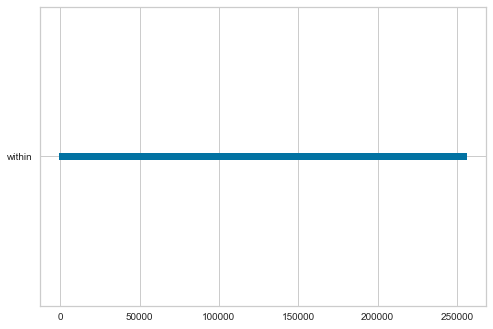

In [34]:
#Troubleshooting tokens to remove
dispersion_text = [doc.split() for doc in df_metadata["LongForm_Clean_Content_Lemma"]]

#Choose words whose occurence in the text will be plotted:
not_found = ["1TABLESANDFIGUREstatefigure","AND FIGUREStatefigure"]
other_words = [token.split() for token in ["within"]]
other_words_1D = np.unique(np.concatenate(other_words).reshape(-1))
target_words = other_words_1D

#Create the visualizer and draw the plot
visualizer = DispersionPlot(target_words,ignore_case=False)
_ = visualizer.fit(dispersion_text)

In [35]:
#Troubleshooting

#df_metadata["Clean_Content"].iloc[38].find("TMH")

#section = df_metadata["Clean_Content"].iloc[38]

#str(section)[1600:1750]

In [36]:
#Make sure spacy is not splitting on - or else terms may be lost such as e-mental
temp_doc = nlp("forensic e-mental Mr. Davis")
#Lemma Removes e-mental
[(token.text,token.lemma_)for token in temp_doc]

[('forensic', 'forensic'),
 ('e', 'e'),
 ('-', '-'),
 ('mental', 'mental'),
 ('Mr.', 'Mr.'),
 ('Davis', 'Davis')]

In [37]:
#df_metadata["emental_Found"] = df_metadata["Content"].apply(lambda text: text.find("forensic emental health"))